# Qualitative analysis of outlier detection 

In [1]:
import numpy as np
import pandas as pd
from geopandas import GeoDataFrame, read_file
from shapely.geometry import Point, LineString, Polygon
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import movingpandas as mpd
#from holoviews import opts, dim
import hvplot
import warnings
warnings.simplefilter("ignore")

from pyproj import Geod
from shapely.ops import nearest_points
import json

## Qualititative analysis based on the shapefile

### Trajectory loading

In [2]:
threshold = 7

In [3]:
df= pd.read_csv("datasets/my_traj.csv")
df["time"] = pd.to_datetime(df["time"],format="mixed")
mpd.TrajectoryCollection(data=df, traj_id_col='id', t='time', x='longitude', y='latitude').hvplot(title='Original Trajectories', line_width=5)

:Overlay
   .Tiles.I  :Tiles   [x,y]
   .Path.I   :Path   [Longitude,Latitude]
   .Points.I :Points   [Longitude,Latitude]   (triangle_angle)

### Shapefile loading

In [7]:
line = "034b"
variante = 1
shapefile= pd.read_csv("datasets/shapefiles.csv", delimiter=";")
shapefile = shapefile[(shapefile["LIGNE"]==line) & (shapefile["VARIANTE"]==variante )]["Geo Shape"].values[0]
shapefile = json.loads(shapefile)

lon = [ shapefile["coordinates"][i][0] for i in range(len(shapefile["coordinates"]))]
lat = [ shapefile["coordinates"][i][1] for i in range(len(shapefile["coordinates"]))]
time = [i*10000000 for i in range(len(shapefile["coordinates"]))]
data = {"longitude":lon, "latitude":lat, "time":time}

df_ = pd.DataFrame(data=data)
df_['id'] = 0
traj_ = mpd.TrajectoryCollection(data=df_, traj_id_col='id', t='time', x='longitude', y='latitude',crs="epsg:31370")
hvplot_defaults = {'tiles':'CartoLight', 'cmap':'Viridis', 'colorbar':True}
traj_.hvplot(title='Line 34',line_width=5,**hvplot_defaults)

:Overlay
   .Tiles.I  :Tiles   [x,y]
   .Path.I   :Path   [Longitude,Latitude]
   .Points.I :Points   [Longitude,Latitude]   (triangle_angle)

### Ground truth computation

In [29]:
from pyproj import CRS, Geod

crs_utm = CRS.from_user_input(31370)
geod = crs_utm.get_geod()  # Your data may be from a different Geod.
distance = np.zeros(len(df))
nearest_points_list = []
df = df.reset_index(drop=True)
line_shape = LineString(shapefile["coordinates"]) 
for index, row in df.iterrows():
    point = Point(row["longitude"], row["latitude"])
    closest_points = nearest_points(line_shape, point)
    nearest_points_list.append(closest_points[0])
    distance[index] = geod.geometry_length(LineString(closest_points))
    
df["distance"] = distance 
mean = df["distance"].mean()
median = df["distance"].median()
std = df["distance"].std()
k=1.5
threshold = median + k * std
#df["nearest_point"] = nearest_points_list
print(mean, std)
outliers = df[df["distance"] > threshold]
is_normal = np.zeros(len(df))
for i in range(len(df['time'].values)):
    if df['time'].values[i] not in outliers['time'].values:
        is_normal[i] = 1
df["is normal"] = is_normal > 0
df

6.99931376823816 6.984997264301602


,time,latitude,longitude,id,distance,is normal
0,2023-06-30 13:34:13+00:00,50.839978,4.365087,0,6.434879,True
1,2023-06-30 13:34:15+00:00,50.840059,4.365243,0,6.241407,True
2,2023-06-30 13:34:17+00:00,50.840115,4.365356,0,6.274832,True
3,2023-06-30 13:34:55+00:00,50.840184,4.365509,0,6.957367,True
4,2023-06-30 13:34:58+00:00,50.840269,4.365628,0,4.605384,True
...,...,...,...,...,...,...
312,2023-06-30 13:55:35+00:00,50.821950,4.404838,0,4.315869,True
313,2023-06-30 13:55:37+00:00,50.821916,4.405050,0,1.384736,True
314,2023-06-30 13:55:39+00:00,50.821854,4.405199,0,3.199198,True
315,2023-06-30 13:55:41+00:00,50.821825,4.405334,0,2.081433,True


In [30]:
#df["distance"].plot(kind='line', title="My plot")

In [31]:
hvplot_defaults = {'tiles':'CartoLight', 'cmap':'Viridis', 'colorbar':True}
kwargs = {**hvplot_defaults, 'c':'distance', 'line_width':7, 'clim':(0,20)}
traj = mpd.TrajectoryCollection(data=df, traj_id_col='id', t='time', x='longitude', y='latitude')
traj.hvplot(title='ground truth', **kwargs)

:Overlay
   .Tiles.I  :Tiles   [x,y]
   .Path.I   :Path   [Longitude,Latitude]   (distance)
   .Points.I :Points   [Longitude,Latitude]   (distance,triangle_angle)

In [32]:
new_traj = mpd.TrajectoryCollection(data=df[df["distance"] <= threshold], traj_id_col='id', t='time', x='longitude', y='latitude')
kwargs = {**hvplot_defaults, 'c':'speed', 'line_width':7, 'clim':(0,20)}
new_traj.hvplot(title='ground truth ', **kwargs)

:Overlay
   .Tiles.I  :Tiles   [x,y]
   .Path.I   :Path   [Longitude,Latitude]   (speed)
   .Points.I :Points   [Longitude,Latitude]   (speed,triangle_angle)

In [10]:
df = traj.to_point_gdf().reset_index()

#### Speed threshold based method

In [11]:
cleaned_df = mpd.OutlierCleaner(traj).clean(v_max=9, units=("m", "s")).to_point_gdf().reset_index()
#cleaned_df["time"] = pd.to_datetime(cleaned_df["time"],utc=True)
cleaned_df.to_csv('csv_results/cleaned_df_mpd_speed_trip.csv', index=False)
cleaned_df

,time,id,distance,is normal,geometry
0,2023-06-30 13:34:13,0,6.434879,True,POINT (4.36509 50.83998)
1,2023-06-30 13:34:15,0,6.241407,True,POINT (4.36524 50.84006)
2,2023-06-30 13:34:17,0,6.274832,True,POINT (4.36536 50.84012)
3,2023-06-30 13:34:55,0,6.957367,True,POINT (4.36551 50.84018)
4,2023-06-30 13:34:58,0,4.605384,True,POINT (4.36563 50.84027)
...,...,...,...,...,...
242,2023-06-30 13:55:35,0,4.315869,True,POINT (4.40484 50.82195)
243,2023-06-30 13:55:37,0,1.384736,True,POINT (4.40505 50.82192)
244,2023-06-30 13:55:39,0,3.199198,True,POINT (4.40520 50.82185)
245,2023-06-30 13:55:41,0,2.081433,True,POINT (4.40533 50.82182)


In [12]:
outlier_df = df.merge(cleaned_df.drop_duplicates(), on=['time'], how='left', indicator=True)
outlier_df = outlier_df[outlier_df["_merge"] == "left_only"]
outlier_df

,time,id_x,distance_x,is normal_x,geometry_x,id_y,distance_y,is normal_y,geometry_y,_merge
32,2023-06-30 13:37:09,0,3.761563,True,POINT (4.36978 50.83981),NaN,NaN,NaN,None,left_only
33,2023-06-30 13:37:11,0,2.121975,True,POINT (4.36998 50.83975),NaN,NaN,NaN,None,left_only
38,2023-06-30 13:37:20,0,9.762360,True,POINT (4.37087 50.83945),NaN,NaN,NaN,None,left_only
39,2023-06-30 13:37:21,0,16.845646,False,POINT (4.37097 50.83937),NaN,NaN,NaN,None,left_only
40,2023-06-30 13:37:23,0,24.545542,False,POINT (4.37116 50.83925),NaN,NaN,NaN,None,left_only
...,...,...,...,...,...,...,...,...,...,...
304,2023-06-30 13:55:19,0,0.909013,True,POINT (4.40335 50.82251),NaN,NaN,NaN,None,left_only
305,2023-06-30 13:55:21,0,0.085689,True,POINT (4.40356 50.82243),NaN,NaN,NaN,None,left_only
306,2023-06-30 13:55:23,0,0.873479,True,POINT (4.40375 50.82235),NaN,NaN,NaN,None,left_only
307,2023-06-30 13:55:25,0,0.534073,True,POINT (4.40393 50.82230),NaN,NaN,NaN,None,left_only


In [13]:
TP = len(cleaned_df[cleaned_df["is normal"] == True])
FP = len(cleaned_df[cleaned_df["is normal"] == False])
TN = len(outlier_df[outlier_df["is normal_x"] == False])
FN = len(outlier_df[outlier_df["is normal_x"] == True])
P = TP / (TP + FP)
A = (TP + TN) / (TP + TN + FP + FN)
R = TP / (TP + FN)
F1 = 2 * (P * R) / (P + R)
print("TP:{}\nFP:{}\nTN:{}\nFN:{}".format(TP,FP,TN,FN))
print("Precision:", round(P,3))
print("Accuracy::",round(A,3))
print("Recall:", round(R,3))
print("F1:", round(F1,3))

TP:218
FP:29
TN:6
FN:64
Precision: 0.883
Accuracy:: 0.707
Recall: 0.773
F1: 0.824


In [14]:
mpd.TrajectoryCollection(data=cleaned_df, traj_id_col='id', t='time', x='longitude', y='latitude',crs="epsg:31370").hvplot(**kwargs)

:Overlay
   .Tiles.I  :Tiles   [x,y]
   .Path.I   :Path   [Longitude,Latitude]   (speed)
   .Points.I :Points   [Longitude,Latitude]   (speed,triangle_angle)

#### IQR based  method

In [33]:
traj.add_speed(overwrite=True)
df_ = traj.to_point_gdf()
series = df_["distance"]
q25, q75 = series.quantile((0.25, 0.75))
iqr = q75 - q25
alpha_1 = (threshold-q75)/(iqr)
alpha_2 = (q25)/(iqr)
alpha = np.max([alpha_1,alpha_2])
flier_high = q75 + alpha * iqr
flier_low = q25 - alpha * iqr
print(q25,q75,iqr,flier_low,flier_high,alpha,np.max(df_["distance"]))

2.482211571501739 9.394288611530337 6.912077040028597 -2.979970264814629 14.856470447846705 0.7902374068871445 51.91761881142342


In [34]:
traj.add_speed(True)
cleaned_df = mpd.IqrCleaner(traj).clean(columns={'distance': alpha}).to_point_gdf().reset_index()
cleaned_df
cleaned_df.to_csv('csv_results/cleaned_df_mpd_iqr_trip_dist.csv', index=False)

In [17]:
outlier_df = df.merge(cleaned_df.drop_duplicates(), on=['time'], how='left', indicator=True)
outlier_df = outlier_df[outlier_df["_merge"] == "left_only"]
outlier_df

,time,id_x,distance_x,is normal_x,geometry_x,id_y,distance_y,is normal_y,geometry_y,speed,_merge
32,2023-06-30 13:37:09,0,3.761563,True,POINT (4.36978 50.83981),NaN,NaN,NaN,None,NaN,left_only
38,2023-06-30 13:37:20,0,9.762360,True,POINT (4.37087 50.83945),NaN,NaN,NaN,None,NaN,left_only
45,2023-06-30 13:37:32,0,16.647453,False,POINT (4.37187 50.83917),NaN,NaN,NaN,None,NaN,left_only
64,2023-06-30 13:38:53,0,11.784644,True,POINT (4.37209 50.83762),NaN,NaN,NaN,None,NaN,left_only
98,2023-06-30 13:41:56,0,0.858093,True,POINT (4.37417 50.83586),NaN,NaN,NaN,None,NaN,left_only
120,2023-06-30 13:43:03,0,13.564840,True,POINT (4.37767 50.83569),NaN,NaN,NaN,None,NaN,left_only
132,2023-06-30 13:43:41,0,6.307232,True,POINT (4.37974 50.83587),NaN,NaN,NaN,None,NaN,left_only
150,2023-06-30 13:44:46,0,4.378975,True,POINT (4.38261 50.83486),NaN,NaN,NaN,None,NaN,left_only
152,2023-06-30 13:44:49,0,0.930106,True,POINT (4.38301 50.83475),NaN,NaN,NaN,None,NaN,left_only
292,2023-06-30 13:55:01,0,8.955597,True,POINT (4.40166 50.82354),NaN,NaN,NaN,None,NaN,left_only


In [18]:
TP = len(cleaned_df[cleaned_df["is normal"] == True])
FP = len(cleaned_df[cleaned_df["is normal"] == False])
TN = len(outlier_df[outlier_df["is normal_x"] == False])
FN = len(outlier_df[outlier_df["is normal_x"] == True])
P = TP / (TP + FP)
A = (TP + TN) / (TP + TN + FP + FN)
R = TP / (TP + FN)
F1 = 2 * (P * R) / (P + R)
print("TP:{}\nFP:{}\nTN:{}\nFN:{}".format(TP,FP,TN,FN))
print("Precision:", round(P,3))
print("Accuracy::",round(A,3))
print("Recall:", round(R,3))
print("F1:", round(F1,3))

TP:273
FP:34
TN:1
FN:9
Precision: 0.889
Accuracy:: 0.864
Recall: 0.968
F1: 0.927


## Qualititative analysis based on the introduction of outliers

In [19]:
df= pd.read_csv("datasets/berlinMOD_with_outliers.csv")
traj = mpd.TrajectoryCollection(data=df, traj_id_col='id', t='time', x='longitude', y='latitude')
traj.hvplot(title='Ground truth', line_width=5)

:Overlay
   .Tiles.I  :Tiles   [x,y]
   .Path.I   :Path   [Longitude,Latitude]
   .Points.I :Points   [Longitude,Latitude]   (triangle_angle)

2.39004238545847 10.361192269118241 7.971149883659772 -12.248765345423289 25.0 1.836473776624143 15190257.590105833


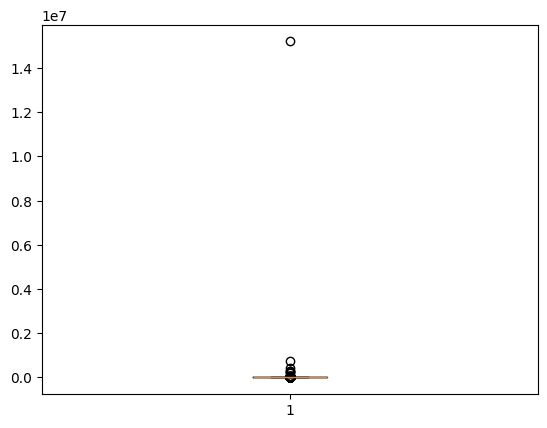

In [20]:
traj.add_speed(overwrite=True, units=("m", "s"))
df_ = traj.to_point_gdf()
series = df_["speed"]
q25, q75 = series.quantile((0.25, 0.75))
iqr = q75 - q25
alpha_1 = (25-q75)/(iqr)
alpha_2 = (q25)/(iqr)
alpha = np.max([alpha_1,alpha_2])
flier_high = q75 + alpha * iqr
flier_low = q25 - alpha * iqr
#data = np.concatenate((series, flier_high, flier_low))
plt.boxplot(series)
print(q25,q75,iqr,flier_low,flier_high,alpha,np.max(df_["speed"]))
plt.show() 
#np.max(df_["speed"])

In [21]:
df = traj.to_point_gdf().reset_index()

#### Speed threshold based method

In [23]:
cleaned_df = mpd.OutlierCleaner(traj).clean(v_max=25, units=("m", "s"))
cleaned_df.to_point_gdf().reset_index().to_csv('csv_results/cleaned_df_mpd_speed_MOD.csv', index=False)
cleaned_df.add_speed(overwrite=True)
cleaned_df = cleaned_df.to_point_gdf().reset_index()
cleaned_df[cleaned_df["is normal"] == False]
cleaned_df

,time,id,OLD_Latitude,OLD_Longitude,is normal,lat_var,lon_var,geometry,speed


In [8]:
outlier_df = df.merge(cleaned_df.drop_duplicates(), on=['time'], how='left', indicator=True)
outlier_df = outlier_df[outlier_df["_merge"] == "left_only"]
outlier_df

,time,id_x,OLD_Latitude_x,OLD_Longitude_x,is normal_x,lat_var_x,lon_var_x,geometry_x,speed_x,id_y,OLD_Latitude_y,OLD_Longitude_y,is normal_y,lat_var_y,lon_var_y,geometry_y,speed_y,_merge
11,2020-06-01 08:56:28.127688,8,50.861891,4.465701,False,0.000000,0.055269,POINT (4.52097 50.86189),9072.580590,NaN,NaN,NaN,NaN,NaN,NaN,None,NaN,left_only
81,2020-06-01 08:58:00.120432,8,50.863289,4.463031,False,0.055235,0.000000,POINT (4.46303 50.91852),24943.350391,NaN,NaN,NaN,NaN,NaN,NaN,None,NaN,left_only
122,2020-06-01 08:58:48.919558,8,50.864420,4.459750,False,0.000000,0.019084,POINT (4.47883 50.86442),2085.422582,NaN,NaN,NaN,NaN,NaN,NaN,None,NaN,left_only
189,2020-06-01 08:59:43.575451,8,50.864706,4.456905,False,0.000000,0.026407,POINT (4.48331 50.86471),393.023444,NaN,NaN,NaN,NaN,NaN,NaN,None,NaN,left_only
343,2020-06-01 09:02:16.763272,8,50.869571,4.458606,False,0.000000,0.090592,POINT (4.54920 50.86957),80406.699081,NaN,NaN,NaN,NaN,NaN,NaN,None,NaN,left_only
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4758,2020-06-04 20:50:08.317145,8,50.863257,4.463085,False,0.016665,0.000000,POINT (4.46309 50.87992),2835.641295,NaN,NaN,NaN,NaN,NaN,NaN,None,NaN,left_only
4780,2020-06-04 20:50:30.665938,8,50.863520,4.462464,False,0.019209,0.000000,POINT (4.46246 50.88273),4918.279012,NaN,NaN,NaN,NaN,NaN,NaN,None,NaN,left_only
4822,2020-06-04 21:54:48.628619,8,50.864398,4.459833,False,0.000000,0.051411,POINT (4.51124 50.86440),11561.317844,NaN,NaN,NaN,NaN,NaN,NaN,None,NaN,left_only
4858,2020-06-04 21:55:29.189371,8,50.863388,4.462826,False,0.000000,0.033574,POINT (4.49640 50.86339),3155.189036,NaN,NaN,NaN,NaN,NaN,NaN,None,NaN,left_only


In [9]:
TP = len(cleaned_df[cleaned_df["is normal"] == True])
FP = len(cleaned_df[cleaned_df["is normal"] == False])
TN = len(outlier_df[outlier_df["is normal_x"] == False])
FN = len(outlier_df[outlier_df["is normal_x"] == True])
P = TP / (TP + FP)
A = (TP + TN) / (TP + TN + FP + FN)
R = TP / (TP + FN)
F1 = 2 * (P * R) / (P + R)
print("TP:{}\nFP:{}\nTN:{}\nFN:{}".format(TP,FP,TN,FN))
print("Precision:", round(P,3))
print("Accuracy::",round(A,3))
print("Recall:", round(R,3))
print("F1:", round(F1,3))

TP:4843
FP:0
TN:99
FN:0
Precision: 1.0
Accuracy:: 1.0
Recall: 1.0
F1: 1.0


#### IQR based  method

In [24]:
traj.add_speed(True)
cleaned_df = mpd.IqrCleaner(traj).clean(columns={'speed':alpha}).to_point_gdf().reset_index()
cleaned_df
cleaned_df.to_csv('csv_results/cleaned_df_mpd_iqr_MOD.csv', index=False)

In [11]:
outlier_df = df.merge(cleaned_df.drop_duplicates(), on=['time'], how='left', indicator=True)
outlier_df = outlier_df[outlier_df["_merge"] == "left_only"]
outlier_df

,time,id_x,OLD_Latitude_x,OLD_Longitude_x,is normal_x,lat_var_x,lon_var_x,geometry_x,speed_x,id_y,OLD_Latitude_y,OLD_Longitude_y,is normal_y,lat_var_y,lon_var_y,geometry_y,speed_y,_merge
11,2020-06-01 08:56:28.127688,8,50.861891,4.465701,False,0.000000,0.055269,POINT (4.52097 50.86189),9072.580590,NaN,NaN,NaN,NaN,NaN,NaN,None,NaN,left_only
12,2020-06-01 08:56:29.028663,8,50.861911,4.465593,True,0.000000,0.000000,POINT (4.46559 50.86191),4327.427237,NaN,NaN,NaN,NaN,NaN,NaN,None,NaN,left_only
81,2020-06-01 08:58:00.120432,8,50.863289,4.463031,False,0.055235,0.000000,POINT (4.46303 50.91852),24943.350391,NaN,NaN,NaN,NaN,NaN,NaN,None,NaN,left_only
82,2020-06-01 08:58:01.200432,8,50.863343,4.462927,True,0.000000,0.000000,POINT (4.46293 50.86334),5683.987505,NaN,NaN,NaN,NaN,NaN,NaN,None,NaN,left_only
122,2020-06-01 08:58:48.919558,8,50.864420,4.459750,False,0.000000,0.019084,POINT (4.47883 50.86442),2085.422582,NaN,NaN,NaN,NaN,NaN,NaN,None,NaN,left_only
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4823,2020-06-04 21:54:49.272284,8,50.864394,4.459851,True,0.000000,0.000000,POINT (4.45985 50.86439),5621.194558,NaN,NaN,NaN,NaN,NaN,NaN,None,NaN,left_only
4858,2020-06-04 21:55:29.189371,8,50.863388,4.462826,False,0.000000,0.033574,POINT (4.49640 50.86339),3155.189036,NaN,NaN,NaN,NaN,NaN,NaN,None,NaN,left_only
4859,2020-06-04 21:55:29.454902,8,50.863380,4.462846,True,0.000000,0.000000,POINT (4.46285 50.86338),8896.730687,NaN,NaN,NaN,NaN,NaN,NaN,None,NaN,left_only
4871,2020-06-04 21:55:44.586342,8,50.863171,4.463224,False,0.000000,0.094170,POINT (4.55739 50.86317),9214.424560,NaN,NaN,NaN,NaN,NaN,NaN,None,NaN,left_only


In [12]:
TP = len(cleaned_df[cleaned_df["is normal"] == True])
FP = len(cleaned_df[cleaned_df["is normal"] == False])
TN = len(outlier_df[outlier_df["is normal_x"] == False])
FN = len(outlier_df[outlier_df["is normal_x"] == True])
P = TP / (TP + FP)
A = (TP + TN) / (TP + TN + FP + FN)
R = TP / (TP + FN)
F1 = 2 * (P * R) / (P + R)
print("TP:{}\nFP:{}\nTN:{}\nFN:{}".format(TP,FP,TN,FN))
print("Precision:", round(P,3))
print("Accuracy::",round(A,3))
print("Recall:", round(R,3))
print("F1:", round(F1,3))

TP:4746
FP:0
TN:99
FN:97
Precision: 1.0
Accuracy:: 0.98
Recall: 0.98
F1: 0.99
